In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.io import mmread
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pymn

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

# Protocol 3: Functional characterization of replicating clusters

Protocol 3 demonstrates how to characterize functional gene sets contributing to cell type identity. In this section, we will focus on the characterization of inhibitory neuron subclasses as provided by the BICCN. The BICCN has shown that subclasses are strongly replicable across datasets and provided marker genes that are specific to each subclass. MetaNeighbor can be used to further quantify which pathways contribute to the subclasses' unique biological properties.

## Step 1 - Creation of biologically relevant gene sets

1. To compute the functional characterization of clusters, we first need an ensemble of gene sets sampling relevant biological pathways. In this protocol we will consider the Gene Ontology (GO) annotation for mouse. The scripts used to build up-to-date gene sets are here XXX, gene sets can be downloaded directly here XXX.  

In [5]:
!curl -L -o go_mouse.mtx https://ndownloader.figshare.com/files/24928064
!curl -L -o go_mouse_row_labels.txt https://ndownloader.figshare.com/files/24928067
!curl -L -o go_mouse_col_labels.txt https://ndownloader.figshare.com/files/24928061
!curl -L -o biccn_gaba.h5ad https://ndownloader.figshare.com/files/24928643

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.9M  100 20.9M    0     0   267k      0  0:01:20  0:01:20 --:--:--  697k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  169k  100  169k    0     0   108k      0  0:00:01  0:00:01 --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1207k  100 1207k    0     0   949k      0  0:00:01  0:00:01 --:--:-- 1874k
  % Total    % Received % Xferd  Average Speed   Tim

In [6]:
go_mtx = mmread('go_mouse.mtx')
go_genes = np.genfromtxt('go_mouse_row_labels.txt', dtype=str)
go_barcodes = np.genfromtxt('go_mouse_col_labels.txt',
                            dtype=str,
                            delimiter='\n')

In [7]:
go_sets = pd.DataFrame(go_mtx.todense(), index=go_genes, columns=go_barcodes)

Gene sets are stored as a named list, each element of the list corresponds to a gene set and contains a vector of gene symbols.

2. Then we load our dataset containing inhibitory neurons from the BICCN. The scripts used to build the dataset can be found here XXX, the dataset can be downloaded here XXX.

In [8]:
biccn_gaba = sc.read_h5ad('biccn_gaba.h5ad')

biccn_gaba.obs.columns = biccn_gaba.obs.columns.astype(str)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [9]:
biccn_gaba.obs['study_id'] = biccn_gaba.obs['study_id'].astype(str)
biccn_gaba.obs['joint_subclass_label'] = biccn_gaba.obs['joint_subclass_label'].astype(str)

3. Next we restrict our gene sets to genes that are present in the dataset. We then filter gene sets to obtain gene sets of meaningful size: large enough to learn expression profiles (> 10), small enough to represent specific biological function or processes (< 100).

In [10]:
go_sets.shape

(24403, 22546)

In [11]:
known_genes = biccn_gaba.var_names
shared_genes = np.intersect1d(known_genes, go_sets.index)
go_sets = go_sets.loc[shared_genes]
min_size = 10
max_size = 100
set_sizes = go_sets.sum()
go_sets = go_sets.loc[:, (set_sizes > min_size) & (set_sizes < max_size)]

In [12]:
go_sets.shape

(20536, 6066)

## Step 2: Functional characterization with supervised MetaNeighbor

4. Once the gene set list is ready, we run the supervised "MetaNeighbor" function. Its inputs are similar to "MetaNeighborUS", but it assumes that cell types have already been matched across datasets (i.e., they have identical names). Here we will use joint BICCN subclasses, for which names have been normalized across datasets ("Pvalb", "Sst", "Sst Chodl", "Vip", "Lamp5", "Sncg"). Note that, because we are testing close to 6,500 gene sets, this step is expected to take a long time for large datasets. We recommend using this function inside a script and always save results to a file as soon as it's done.

> **PERFORMANCE NOTE 1** The `pymn.MetaNeighbor` function has 2 boolean paramters that control the speed and memory usage of the program. These parameters are `fast_version` and `fast_hi_mem`. The **slowest and highest memory** configuration is `fast_version=False` `fast_hi_mem=True`. The **lowest memory** configuration is `fast_version=True` and `fast_hi_mem=False`. To increase the speed and use a little bit more memory you can use `fast_version=True` `fast_hi_mem=True`. For the example below this requires about ~15GB of memory to run, but increases the speed from the **lowest memory** version by about 60%.


> **PERFORMANCE NOTE 2** If you are running this on a computer/server with many cores/threads you might lose performance if you are using too many threads becasue of the overhead needed to start threads. You can control the number of threads using `import mkl; mkl.set_num_threads(n_threads)`. For our servers we found 8 threads to be the ideal amount. You can test it by running a few gene sets (10 or 100, `go_sets.iloc[:,:100]`) with different thread counts to see what the fastest is before running all the gene sets

In [13]:
import mkl; mkl.set_num_threads(8)

48

In [14]:
%%time
pymn.MetaNeighbor(adata=biccn_gaba,
                  study_col='study_id',
                  ct_col='joint_subclass_label',
                  genesets=go_sets,
                  fast_version=True,
                  fast_hi_mem=False)

biccn_gaba.uns['MetaNeighbor'].to_csv('functional_aurocs.csv')

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/pyMN/pymn/utils.py:102: RuntimeWarning: invalid value encountered in true_divide
  result /= n_neg[:, None]
/home/bharris/pyMN/pymn/MetaNeighbor.py:100: RuntimeWarning: Mean of empty slice
  res = np.nanmean(pd.DataFrame(res), axis=1)


CPU times: user 5h 27min 26s, sys: 21min 50s, total: 5h 49min 16s
Wall time: 48min 25s


Later, results can be retrieved with the `pd.read_csv` function:

In [15]:
aurocs = pd.read_csv("functional_aurocs.csv", index_col=0)
biccn_gaba.uns['MetaNeighbor'] = aurocs
biccn_gaba.uns['MetaNeighbor_params'] = {'study_col':'study_id',
                                         'ct_col':'joint_subclass_label'}


5. We use the "plotBPlot" function on the first 100 gene sets to rapidly visualize how replicability depends on gene sets.

In [16]:
biccn_gaba.uns['MetaNeighbor'].to_csv('functional_aurocs.csv')

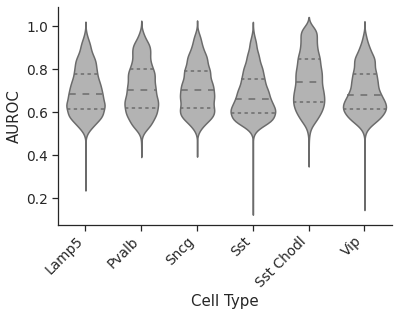

In [17]:
pymn.plotMetaNeighbor(aurocs)

If you pass the AnnData object with the results stored in `.uns` you can also color by cell-type if you want it to match other data. You can save a colormap as a dictionary of `{celltype:color}` under `adata.uns['{ct_col}_colors_dict']` to be consistent with your other plots, or let the program generate one from a given color palette under the `palette` parameter

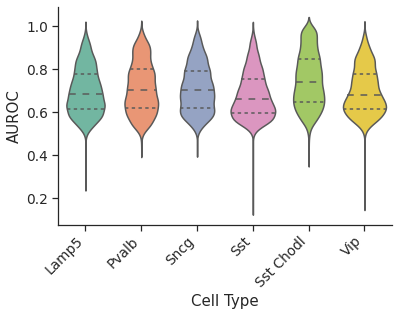

In [18]:
pymn.plotMetaNeighbor(biccn_gaba,color='Cell Type')

We note that, on average, gene sets contribute moderately to replicability (AUROC ~ 0.7), numerous gene sets have a performance close to random (AUROC ~ 0.5 - 0.6) and some gene sets have exceedingly high performance (AUROC > 0.8).

6. To focus on gene sets that contribute highly to specificity, we create a summary table containing, for each gene set, cell type specific AUROCs, average AUROC across all cell types and gene set size.

In [19]:
gs_size = go_sets.sum()
aurocs.loc['average_auroc'] = aurocs.mean()
aurocs.loc['gs_size'] = gs_size[aurocs.columns]

We then order gene set by AUROC and look at top scoring gene sets:

In [20]:
aurocs.T.sort_values('average_auroc', ascending=False).head(10)

Cell Type,Lamp5,Pvalb,Sncg,Sst,Sst Chodl,Vip,average_auroc,gs_size
GO:0007215|glutamate receptor signaling pathway|BP,0.967138,0.984908,0.970894,0.979208,0.995992,0.986477,0.980770,92.0
"GO:0051966|regulation of synaptic transmission, glutamatergic|BP",0.959517,0.971045,0.975293,0.965359,0.992332,0.973365,0.972819,75.0
GO:0033555|multicellular organismal response to stress|BP,0.952360,0.975076,0.974724,0.947405,0.999145,0.975227,0.970656,98.0
GO:0060076|excitatory synapse|CC,0.960445,0.966509,0.988698,0.964131,0.986668,0.957072,0.970587,75.0
GO:0098839|postsynaptic density membrane|CC,0.924088,0.970252,0.983317,0.983514,0.983329,0.970110,0.969101,93.0
"GO:0099565|chemical synaptic transmission, postsynaptic|BP",0.968255,0.977103,0.972916,0.951548,0.987180,0.955344,0.968724,91.0
GO:0099601|regulation of neurotransmitter receptor activity|BP,0.954515,0.974748,0.954839,0.951108,0.993929,0.975712,0.967475,61.0
GO:0060079|excitatory postsynaptic potential|BP,0.966917,0.976322,0.969234,0.950889,0.986148,0.953739,0.967208,83.0
GO:1900449|regulation of glutamate receptor signaling pathway|BP,0.953087,0.970946,0.952778,0.950950,0.994219,0.972911,0.965815,56.0
GO:0010771|negative regulation of cell morphogenesis involved in differentiation|BP,0.979016,0.974905,0.970633,0.959184,0.986028,0.924774,0.965757,98.0


Without surprise, replicability is mainly driven by gene sets related to neuronal functions that are immediately relevant to the physiology of inhibitory neurons, such as "glutamate receptor signaling pathway", "regulation of synaptic transmission, glutamatergic", or "chemical synaptic transmission, postsynaptic". Note that most of the top scoring gene sets have a large number of genes. To obtain even more specific biological function, we can further filter gene sets that have fewer than 20 genes.

In [21]:
small_sets = aurocs.T[aurocs.T['gs_size'] < 20]
small_sets.sort_values('average_auroc', ascending=False).head(10)

Cell Type,Lamp5,Pvalb,Sncg,Sst,Sst Chodl,Vip,average_auroc,gs_size
GO:0004970|ionotropic glutamate receptor activity|MF,0.900527,0.917350,0.914096,0.957223,0.966349,0.922562,0.929684,19.0
GO:0035235|ionotropic glutamate receptor signaling pathway|BP,0.822718,0.821832,0.905512,0.928740,0.942784,0.866258,0.881307,16.0
"GO:0032230|positive regulation of synaptic transmission, GABAergic|BP",0.844397,0.856076,0.815510,0.920014,0.984549,0.829219,0.874961,16.0
GO:0007216|G protein-coupled glutamate receptor signaling pathway|BP,0.889939,0.848807,0.763517,0.915839,0.951083,0.842163,0.868558,16.0
GO:1905874|regulation of postsynaptic density organization|BP,0.829720,0.862467,0.865795,0.903003,0.916684,0.825713,0.867230,19.0
GO:0099150|regulation of postsynaptic specialization assembly|BP,0.833023,0.892884,0.855117,0.909915,0.909895,0.801576,0.867068,18.0
GO:0150052|regulation of postsynapse assembly|BP,0.833023,0.892884,0.855117,0.909915,0.909895,0.801576,0.867068,18.0
GO:0021889|olfactory bulb interneuron differentiation|BP,0.807886,0.913701,0.824044,0.883605,0.891491,0.864433,0.864193,15.0
"GO:0070679|inositol 1,4,5 trisphosphate binding|MF",0.920570,0.940097,0.790576,0.806067,0.863020,0.852639,0.862161,15.0
GO:1902711|GABA-A receptor complex|CC,0.820995,0.868930,0.869553,0.801762,0.990820,0.795980,0.858007,19.0


Again, the top scoring gene sets are dominated by biological functions immediately relevant to inhibitory neuron physiology, such as "ionotropic glutamate receptor signaling pathway", "positive regulation of synaptic transmission, GABAergic", or "GABA-A receptor complex".

7. To understand how individual genes contribute to gene set performance, we use the "plotDotPlot" function, which while show the expression of all genes in a gene set of interest, averaged over all datasets.

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/pyMN/pymn/plotting.py:77: RuntimeWarning: invalid value encountered in true_divide
  axis=0) / np.nansum(M2, axis=1)


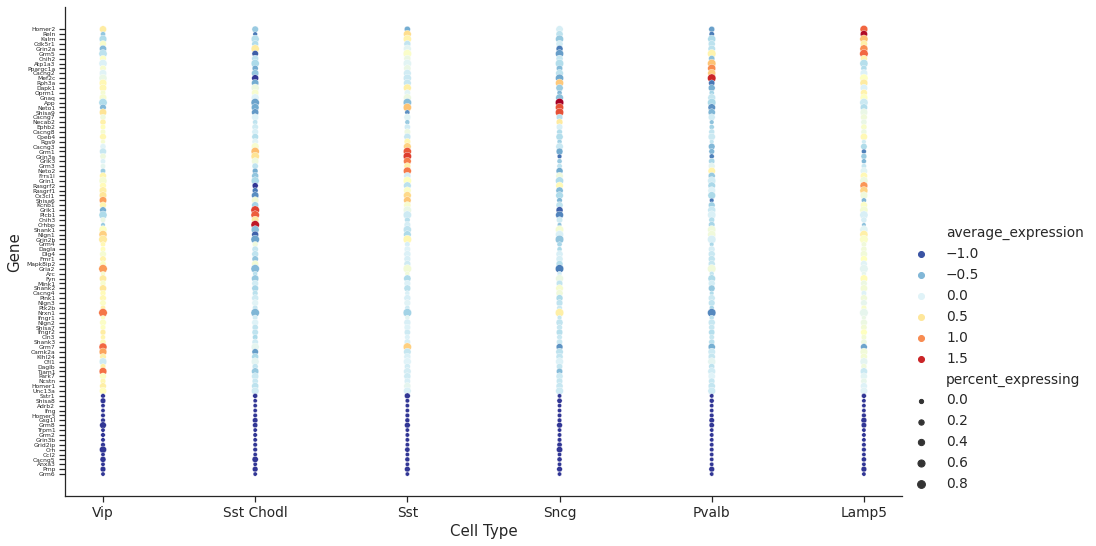

In [22]:
pymn.plotDotPlot(biccn_gaba,
                 go_sets["GO:0007215|glutamate receptor signaling pathway|BP"],
                 average_expressing_only=True,
                 fontsize=6,
                 figsize=(15, 9))

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/pyMN/pymn/plotting.py:77: RuntimeWarning: invalid value encountered in true_divide
  axis=0) / np.nansum(M2, axis=1)


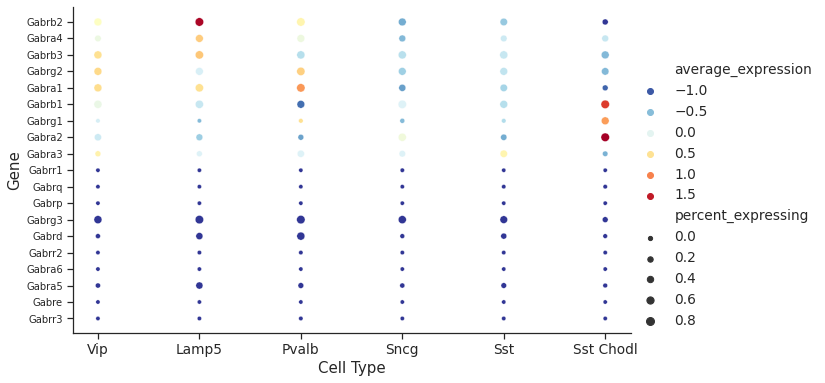

In [23]:
pymn.plotDotPlot(biccn_gaba,
                 go_sets["GO:1902711|GABA-A receptor complex|CC"],
                 average_expressing_only=True)

High scoring gene sets are characterized by the differential usage of genes from a given gene set. For example, when looking at the GABA-A receptor complex composition, Lamp5 will preferentially use the Gabrb2 and Gabrg3 receptors, Pvalb the Gabra1 receptor, and Sst Chodl the Gabra2, Gabrb1 and Gabrg1 receptors.

Once the overall replicability of clusters has been established with unsupervised MetaNeighbor (as in Protocols 1 and 2), supervised MetaNeighbor enables the functional interpretation of the biology contributing to each cell type's unique identity.